# Análisis del problema 

Un aumento en las tasas de incumplimiento de los clientes es malo para Credit One ya que su negocio está aprobando préstamos para clientes en primer lugar. 

El cuaderno está estructurado de la siguiente manera:

- Limpieza y preprocesamiento
- Estimación de covarianza
- EDA
- Ingeniería de características (PCA o RFE) y reducción de dimensionalidad
- Codificación en caliente (si es necesario)
- Clasificación  (Construye tres modelos y elige el mejor)
- Ajuste del modelo  ( ajuste al menos dos parámetros para cada modelo que construya)
- Evaluación modelo

In [95]:
#imports
#numpy,pandas,scipy, math, matplotlib
import numpy as np
import pandas as pd
import scipy
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

#estimators
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#model metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn import metrics

#cross validation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import missingno as msno 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score



# Limpieza y preprocesamiento

In [2]:
#Carga los datos 
credit = pd.read_csv('default_of _credit_card_clients.csv', header =1)

In [3]:
print("Datos de clientes de tarjeta de crédito predeterminados -  filas:",credit.shape[0]," columnas:", credit.shape[1])

Datos de clientes de tarjeta de crédito predeterminados -  filas: 30000  columnas: 25


In [4]:
#Verificar datos para cualquier valor faltante
credit.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
credit.isnull().sum()
#No hay valores nulos

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

In [6]:
total = credit.isnull().sum().sort_values(ascending = False)
percent = (credit.isnull().sum()/credit.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,default payment next month,PAY_6,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,ID
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


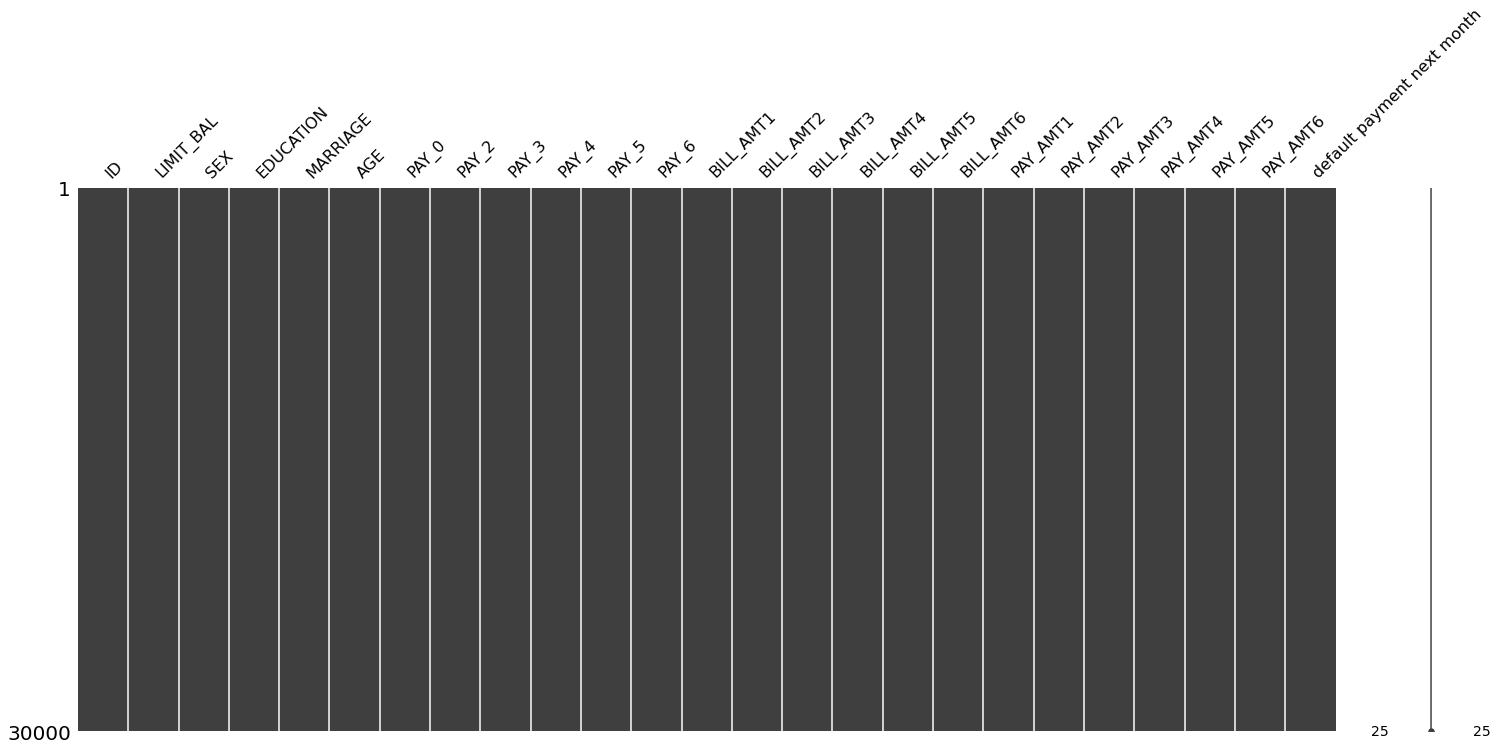

In [7]:
msno.matrix(credit) 

Verifique el valor único de cada variable categórica

In [8]:
print('Sexo ' + str(sorted(credit['SEX'].unique())))
print('Educación ' + str(sorted(credit['EDUCATION'].unique())))
print('Matrinomio ' + str(sorted(credit['MARRIAGE'].unique())))
print('Pago 0 ' + str(sorted(credit['PAY_0'].unique())))
print('Pago el siguiente mes' + str(sorted(credit['default payment next month'].unique())))

Sexo [1, 2]
Educación [0, 1, 2, 3, 4, 5, 6]
Matrinomio [0, 1, 2, 3]
Pago 0 [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
Pago el siguiente mes[0, 1]


In [9]:
fill = (credit.EDUCATION == 0) | (credit.EDUCATION == 5) | (credit.EDUCATION == 6)
credit.loc[fill, 'EDUCATION'] = 4

print('Educación ' + str(sorted(credit['EDUCATION'].unique())))

Educación [1, 2, 3, 4]


- El valor en EDUCACIÓN no se define completamente. Dado que 0, 4, 5, 6 se definen como otros (o desconocidos), será mejor agruparlos y nombrarlos 4.

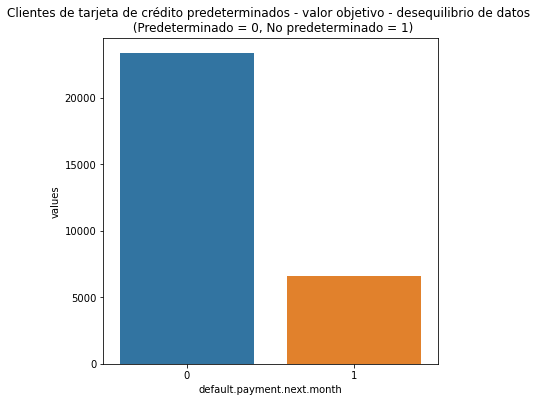

In [10]:
temp = credit["default payment next month"].value_counts()
df = pd.DataFrame({'default.payment.next.month': temp.index,'values': temp.values})
plt.figure(figsize = (6,6))
plt.title('Clientes de tarjeta de crédito predeterminados - valor objetivo - desequilibrio de datos \n (Predeterminado = 0, No predeterminado = 1)')
sns.set_color_codes("pastel")
sns.barplot(x = 'default.payment.next.month', y="values", data=df)
locs, labels = plt.xticks()
plt.show()

# Estimación de covarianza

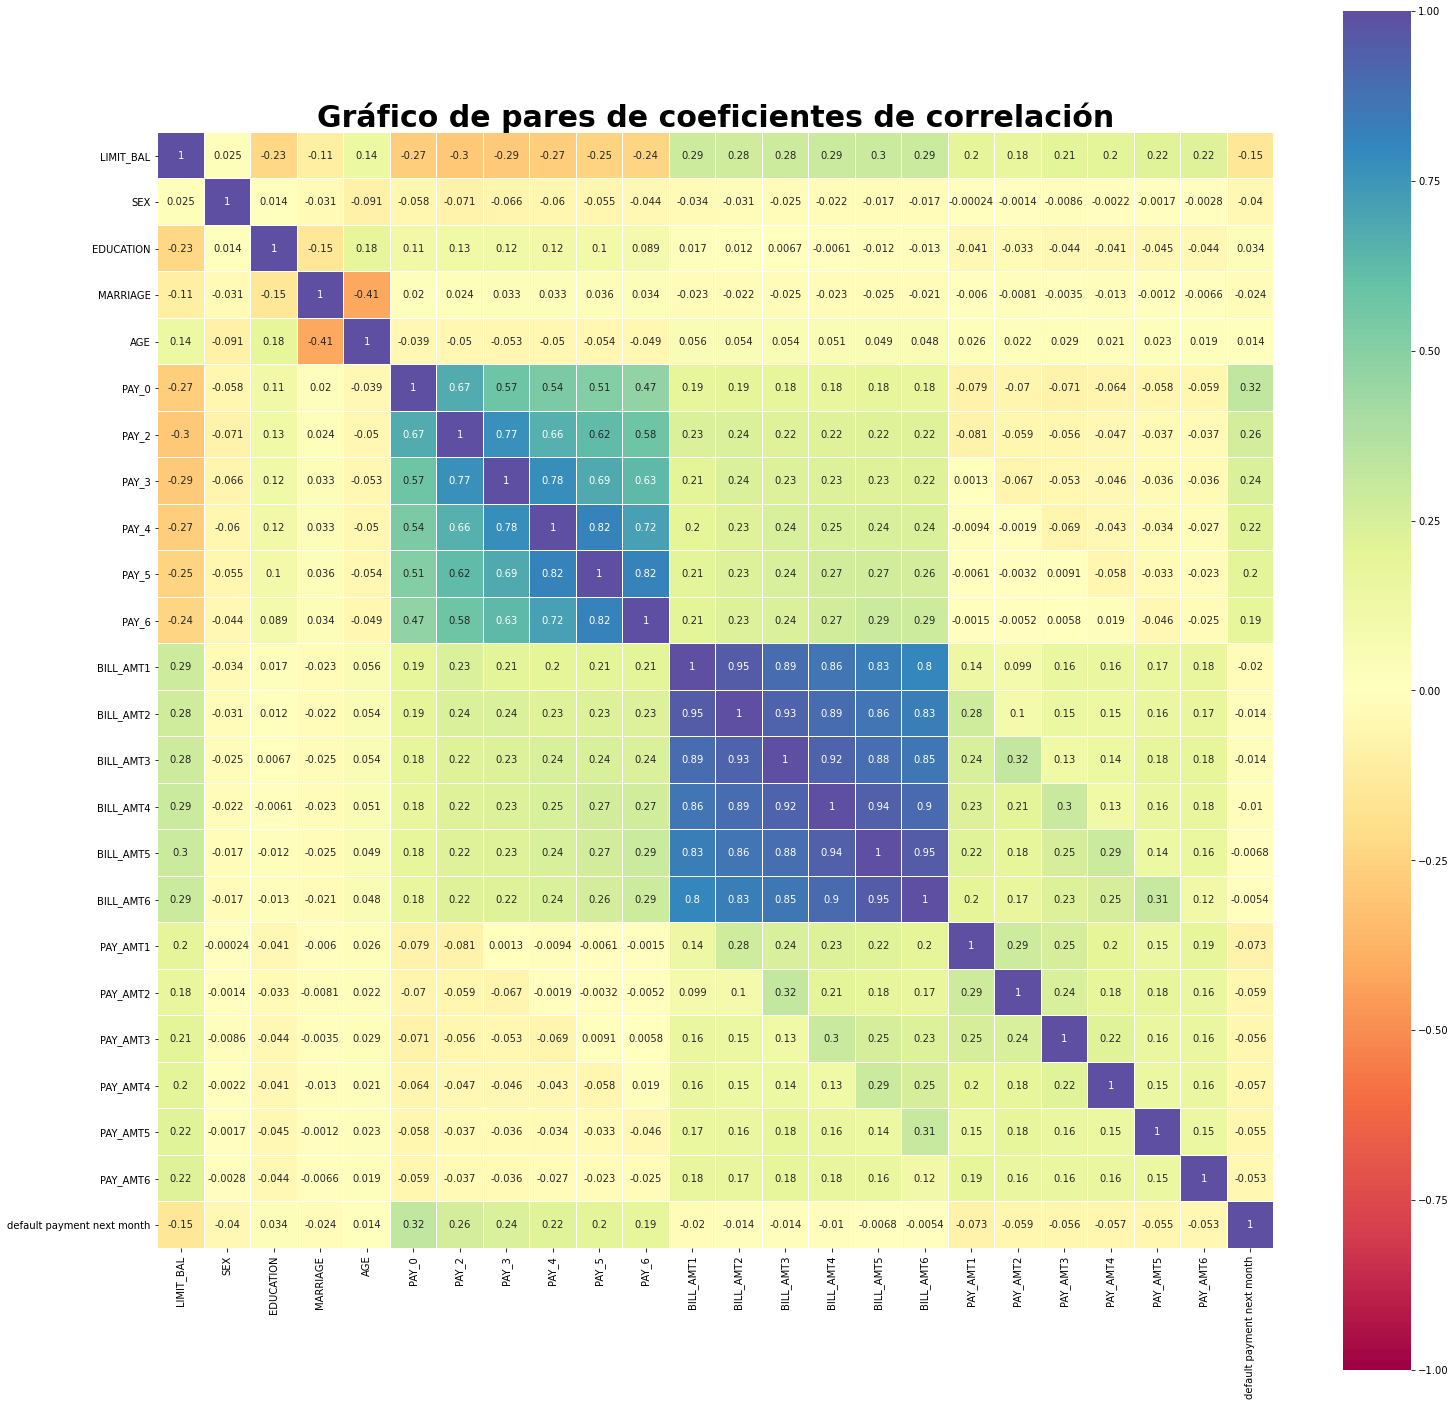

In [12]:
# Hacer que los coeficientes de correlación emparejen la gráfica de todas las características para identificar las características degeneradas
plt.figure(figsize=(25,25))
ax = plt.axes()
corr = credit.drop(['ID'], axis=1).corr()
sns.heatmap(corr, vmax=1,vmin=-1, square=True, annot=True, cmap='Spectral',linecolor="white", linewidths=0.01, ax=ax)
ax.set_title('Gráfico de pares de coeficientes de correlación',fontweight="bold", size=30)
plt.show()

- Entre las variables Bills existe mucha correlación
- Entre las variables Pay NO existe mucha correlación

# EDA

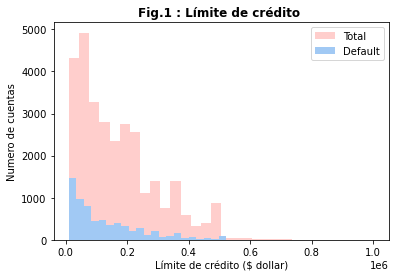

In [13]:
# Credit Limit (Feature name :'LIMIT_BAL' )
%matplotlib inline
bins = 30
plt.hist(credit.LIMIT_BAL, bins = bins, color='r',label = 'Total',alpha=0.5)
plt.hist(credit.LIMIT_BAL[credit['default payment next month'] == 1], bins = bins, color='b',label = 'Default')

plt.xlabel('Límite de crédito ($ dollar)');plt.ylabel('Numero de cuentas')
plt.title('Fig.1 : Límite de crédito ',fontweight="bold", size=12)
plt.legend();plt.show()

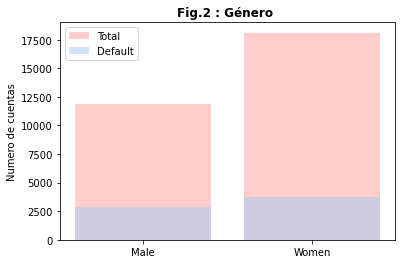

In [15]:
# Gender (Feature name :'SEX' )
men = credit['SEX'][credit['SEX']==1].count()
men_default = credit['SEX'][(credit['SEX']==1)&(credit['default payment next month']==1)].count()

women = credit['SEX'][credit['SEX']==2].count()
women_default = credit['SEX'][(credit['SEX']==2)&(credit['default payment next month']==1)].count()

total_sex = [men, women]
default_sex = [men_default,women_default]
gender = [1,2]
plt.bar(gender,total_sex, color='r',alpha=0.5, label='Total')
plt.bar(gender,default_sex, color='b',alpha=0.5, label='Default')

plt.xticks([1,2],['Male','Women']);plt.ylabel('Numero de cuentas')
plt.title('Fig.2 : Género ',fontweight="bold", size=12)
plt.legend();plt.show()

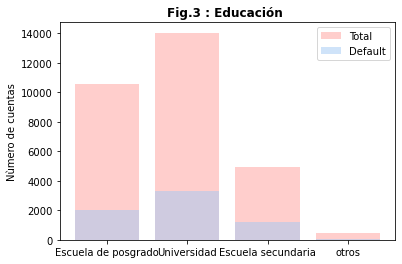

In [19]:
# Education (Feature name :'EDUCATION' )
grad =  credit['EDUCATION'][credit['EDUCATION']==1].count()
grad_default = credit['EDUCATION'][(credit['EDUCATION']==1)&(credit['default payment next month']==1)].count()

uni =  credit['EDUCATION'][credit['EDUCATION']==2].count()
uni_default = credit['EDUCATION'][(credit['EDUCATION']==2)&(credit['default payment next month']==1)].count()

high =  credit['EDUCATION'][credit['EDUCATION']==3].count()
high_default = credit['EDUCATION'][(credit['EDUCATION']==3)&(credit['default payment next month']==1)].count()

other =  credit['EDUCATION'][credit['EDUCATION'] > 3].count()
other_default = credit['EDUCATION'][(credit['EDUCATION'] > 3)&(credit['default payment next month']==1)].count()

total_education = [grad, uni, high, other]
default_education = [grad_default,uni_default,high_default, other_default]
degree = [1,2,3,4]
plt.bar(degree,total_education, color='r',alpha=0.5, label='Total')
plt.bar(degree,default_education, color='b',alpha=0.5, label='Default')

plt.xticks([1,2,3,4],['Escuela de posgrado', 'Universidad', 'Escuela secundaria', 'otros'])
plt.ylabel('Nùmero de cuentas');plt.title('Fig.3 : Educación ',fontweight="bold", size=12)
plt.legend();plt.show()

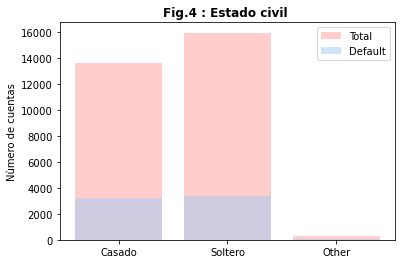

In [21]:
married =  credit['MARRIAGE'][credit['MARRIAGE']==1].count()
married_default = credit['MARRIAGE'][(credit['MARRIAGE']==1)&(credit['default payment next month']==1)].count()

single =  credit['MARRIAGE'][credit['MARRIAGE']==2].count()
single_default = credit['MARRIAGE'][(credit['MARRIAGE']==2)&(credit['default payment next month']==1)].count()

other =  credit['MARRIAGE'][credit['MARRIAGE']==3].count()
other_default = credit['MARRIAGE'][(credit['MARRIAGE']==3)&(credit['default payment next month']==1)].count()

total_marriage = [married, single, other]
default_marriage = [married_default,single_default,other_default]
status = [1,2,3]
plt.bar(status,total_marriage, color='r',alpha=0.5, label='Total')
plt.bar(status,default_marriage, color='b',alpha=0.5, label='Default')

plt.xticks([1,2,3],['Casado','Soltero','Other']); plt.ylabel('Nùmero de cuentas')
plt.title('Fig.4 : Estado civil ',fontweight="bold", size=12)
plt.legend(); plt.show()

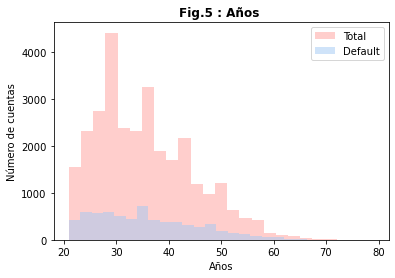

In [23]:
# Age (Feature name :'AGE' )
bins = 25

plt.hist(credit['AGE'],bins = bins, color='r',label = 'Total',alpha=0.5)
plt.hist(credit['AGE'][credit['default payment next month']==1], bins = bins, color='b',label = 'Default',alpha=0.5)

plt.xlabel('Años'); plt.ylabel('Número de cuentas')
plt.title('Fig.5 : Años ',fontweight="bold", size=12)
plt.legend();plt.show()

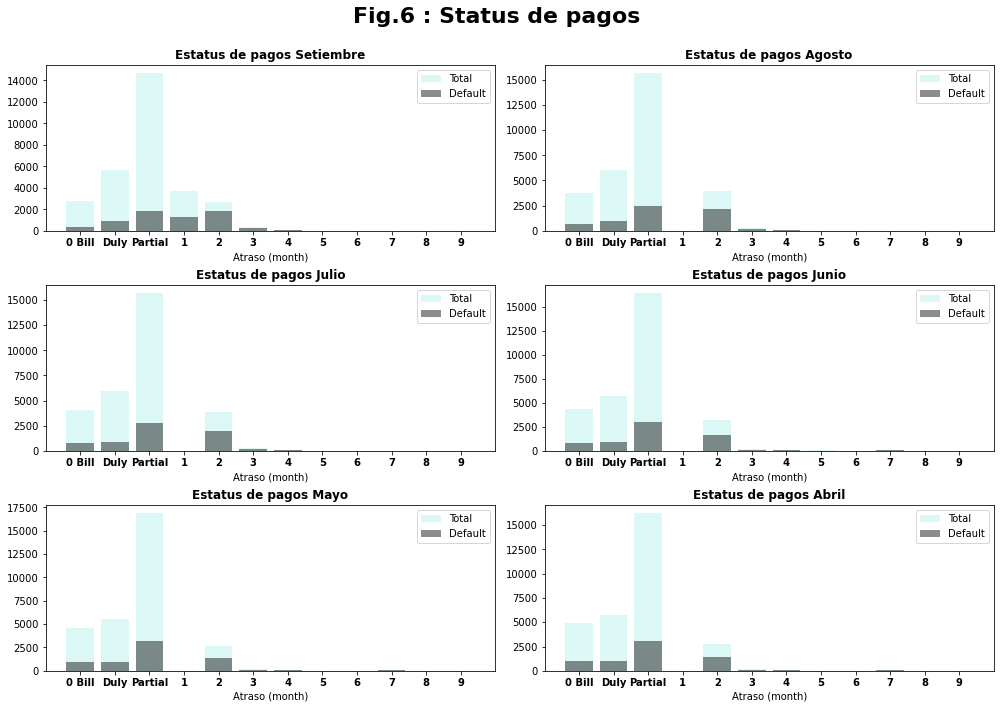

In [27]:
import matplotlib.gridspec as gridspec
features = list(credit.columns)
plt.figure(figsize=(14,10))

gs = gridspec.GridSpec(3,2)
i = 0

plt.suptitle('Fig.6 : Status de pagos ',fontweight="bold", fontsize=22)
for cn in features[6:12]:
    ax = plt.subplot(gs[i])
    delay = np.zeros(12)
    delay_default = np.zeros(12)  
    for j in np.arange(0,12):
            delay[j] = credit[cn][credit[cn]==j-2].count()
            delay_default[j] = credit[cn][(credit[cn]==j-2)&(credit['default payment next month']==1)].count()  

    month = [-2,-1,0,1,2,3,4,5,6,7,8,9]
    plt.bar(month,delay, color='c',alpha=0.5, label='Total')
    plt.bar(month,delay_default, color='k',alpha=0.5, label='Default')

    plt.xticks([-2,-1,0,1,2,3,4,5,6,7,8,9],['0 Bill','Duly','Partial','1','2','3','4','5','6','7','8','9'], fontweight="bold", size=10)
    ax.set_xlabel('Atraso (month)')
    months = ['Setiembre','Agosto','Julio','Junio','Mayo','Abril']
    ax.set_title('Estatus de pagos ' + months[i], fontweight="bold", size=12)
    ax.legend()
    i+=1
    
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

# Feature Engineering 

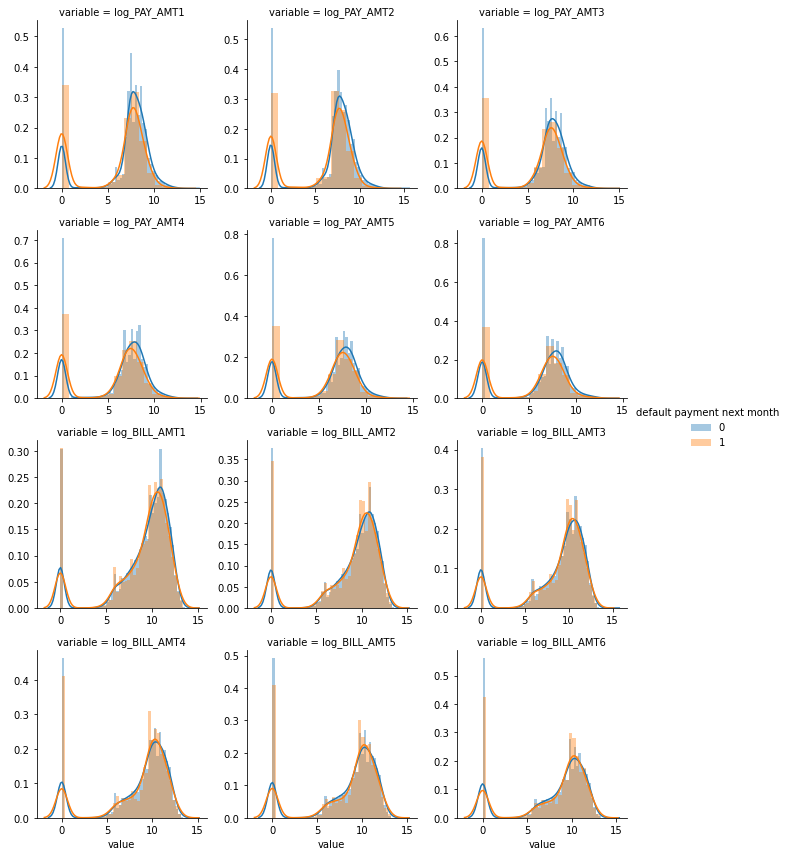

In [28]:
output = 'default payment next month'

# Let's do a little EDA
cols = [ f for f in credit.columns if credit.dtypes[ f ] != "object"]
cols.remove( "ID")
cols.remove( output )

# The quantitative vars:
quant = ["LIMIT_BAL", "AGE"]

# The qualitative but "Encoded" variables (ie most of them)
qual_Enc = cols
qual_Enc.remove("LIMIT_BAL")
qual_Enc.remove("AGE")

logged = []
for ii in range(1,7):
    qual_Enc.remove("PAY_AMT" + str( ii ))
    credit[ "log_PAY_AMT" + str( ii )]  = credit["PAY_AMT"  + str( ii )].apply( lambda x: np.log1p(x) if (x>0) else 0 )
    logged.append("log_PAY_AMT" + str( ii ) )

for ii in range(1,7):
    qual_Enc.remove("BILL_AMT" + str( ii ))
    credit[ "log_BILL_AMT" + str( ii )] = credit["BILL_AMT" + str( ii )].apply( lambda x: np.log1p(x) if (x>0) else 0 )
    logged.append("log_BILL_AMT" + str( ii ) )

f = pd.melt( credit, id_vars=output, value_vars=logged)
g = sns.FacetGrid( f, hue=output, col="variable", col_wrap=3, sharex=False, sharey=False )
g = g.map( sns.distplot, "value", kde=True).add_legend()

In [32]:
#features
features = quant + qual_Enc + logged   
X = credit[features].values    
y = credit[ output ].values


X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2)

from sklearn.preprocessing import StandardScaler
scX = StandardScaler()
X_train = scX.fit_transform( X_train )
X_test = scX.transform( X_test )


# Classificación

In [75]:
#-------------- 
# kernel SVM 
#--------------
classifier1 = SVC(kernel="rbf",C=1.0,probability=True)
classifier1.fit( X_train, y_train )

y_pred1 = classifier1.predict( X_test )
probs1 = classifier1.predict_proba( X_test )

train_predictions1 = classifier1.predict(X_train)
train_probs1 = classifier1.predict_proba(X_train)

cm = confusion_matrix( y_test, y_pred )
print("Accuracy on Test Set for kernel-SVM = %.2f" % ((cm[0,0] + cm[1,1] )/len(X_test)))
scoresSVC = cross_val_score( classifier1, X_train, y_train, cv=10)
print("Mean kernel-SVM CrossVal Accuracy on Train Set %.2f, with std=%.2f" % (scoresSVC.mean(), scoresSVC.std() ))
classifier1.score(X_train,y_train)

Accuracy on Test Set for kernel-SVM = 0.82
Mean kernel-SVM CrossVal Accuracy on Train Set 0.82, with std=0.01


0.8282916666666666

In [104]:
#-------------- 
# Logistic Regression 
classifier2 = LogisticRegression(random_state=0,C=1.0)
classifier2.fit( X_train, y_train )

y_pred2 = classifier2.predict( X_test )
probs2 = classifier2.predict_proba( X_test )

train_predictions2 = classifier2.predict(X_train)
train_probs2 = classifier2.predict_proba(X_train)

cm = confusion_matrix( y_test, y_pred )
print("Accuracy on Test Set for LogReg = %.2f" % ((cm[0,0] + cm[1,1] )/len(X_test)))
scoresLR = cross_val_score( classifier2, X_train, y_train, cv=10)
print("Mean LogReg CrossVal Accuracy on Train Set %.2f, with std=%.2f" % (scoresLR.mean(), scoresLR.std() ))
classifier2.score(X_train,y_train)

Accuracy on Test Set for LogReg = 0.82
Mean LogReg CrossVal Accuracy on Train Set 0.81, with std=0.00


0.8065833333333333

In [105]:
#-------------- 
# Naive Bayes 
#--------------
classifier3 = RandomForestClassifier(n_estimators=100, criterion='gini')
classifier3.fit( X_train, y_train )

y_pred3 = classifier3.predict( X_test )
probs3 = classifier3.predict_proba( X_test )

train_predictions3 = classifier3.predict(X_train)
train_probs3 = classifier3.predict_proba(X_train)

cm = confusion_matrix( y_test, y_pred )
print("Accuracy on Test Set for NBClassifier = %.2f" % ((cm[0,0] + cm[1,1] )/len(X_test)))
scoresNB = cross_val_score( classifier3, X_train, y_train, cv=10)
print("Mean NaiveBayes CrossVal Accuracy on Train Set %.2f, with std=%.2f" % (scoresNB.mean(), scoresNB.std() ))
classifier3.score(X_train,y_train)

Accuracy on Test Set for NBClassifier = 0.82
Mean NaiveBayes CrossVal Accuracy on Train Set 0.81, with std=0.01


0.9994583333333333

In [106]:
#-------------- 
# K-NEIGHBOURS 
#--------------
from sklearn.neighbors import KNeighborsClassifier
classifier4 = KNeighborsClassifier(n_neighbors=5,weights= 'uniform')
classifier4.fit( X_train, y_train )

y_pred4 = classifier3.predict( X_test )
probs4= classifier3.predict_proba( X_test )

train_predictions4 = classifier3.predict(X_train)
train_probs4 = classifier3.predict_proba(X_train)

cm = confusion_matrix( y_test, y_pred )
print("Accuracy on Test Set for KNeighborsClassifier = %.2f" % ((cm[0,0] + cm[1,1] )/len(X_test)))
scoresKN = cross_val_score( classifier3, X_train, y_train, cv=10)
print("Mean KN CrossVal Accuracy on Train Set Set %.2f, with std=%.2f" % (scoresKN.mean(), scoresKN.std() ))
classifier4.score(X_train,y_train)

Accuracy on Test Set for KNeighborsClassifier = 0.82
Mean KN CrossVal Accuracy on Train Set Set 0.82, with std=0.01


0.8425416666666666

# Evaluación

In [107]:
def evaluate_model(predictions, probs, train_predictions, train_probs, model):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = metrics.roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = metrics.roc_curve(y_test, probs)
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title(model+' ROC Curves');

Recall Baseline: 1.0 Test: 0.34 Train: 0.37
Precision Baseline: 0.21 Test: 0.68 Train: 0.73
Roc Baseline: 0.5 Test: 0.71 Train: 0.81


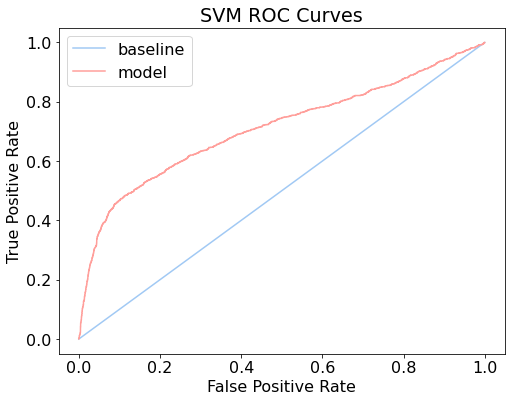

In [108]:
evaluate_model(y_pred1, probs1[:, 1], train_predictions1, train_probs1[:, 1], "SVM ")


Recall Baseline: 1.0 Test: 0.25 Train: 0.26
Precision Baseline: 0.21 Test: 0.66 Train: 0.67
Roc Baseline: 0.5 Test: 0.73 Train: 0.75


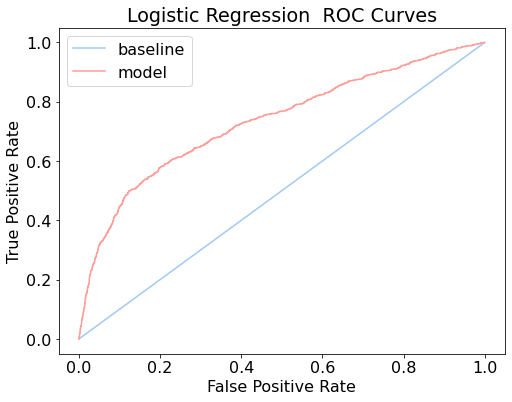

In [109]:
evaluate_model(y_pred2, probs2[:, 1], train_predictions2, train_probs2[:, 1], "Logistic Regression ")

Recall Baseline: 1.0 Test: 0.36 Train: 1.0
Precision Baseline: 0.21 Test: 0.63 Train: 1.0
Roc Baseline: 0.5 Test: 0.76 Train: 1.0


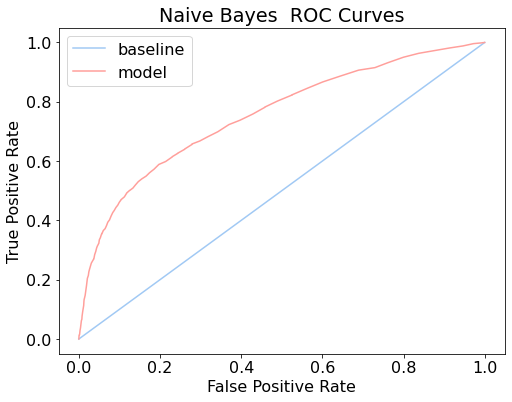

In [110]:
evaluate_model(y_pred3, probs3[:, 1], train_predictions3, train_probs3[:, 1], "Naive Bayes ")

Recall Baseline: 1.0 Test: 0.36 Train: 1.0
Precision Baseline: 0.21 Test: 0.63 Train: 1.0
Roc Baseline: 0.5 Test: 0.76 Train: 1.0


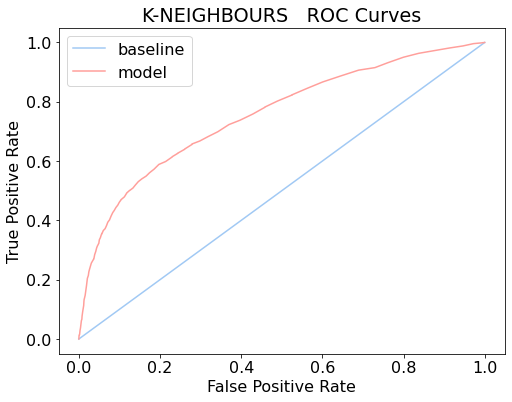

In [111]:
evaluate_model(y_pred4, probs4[:, 1], train_predictions4, train_probs4[:, 1], "K-NEIGHBOURS  ")

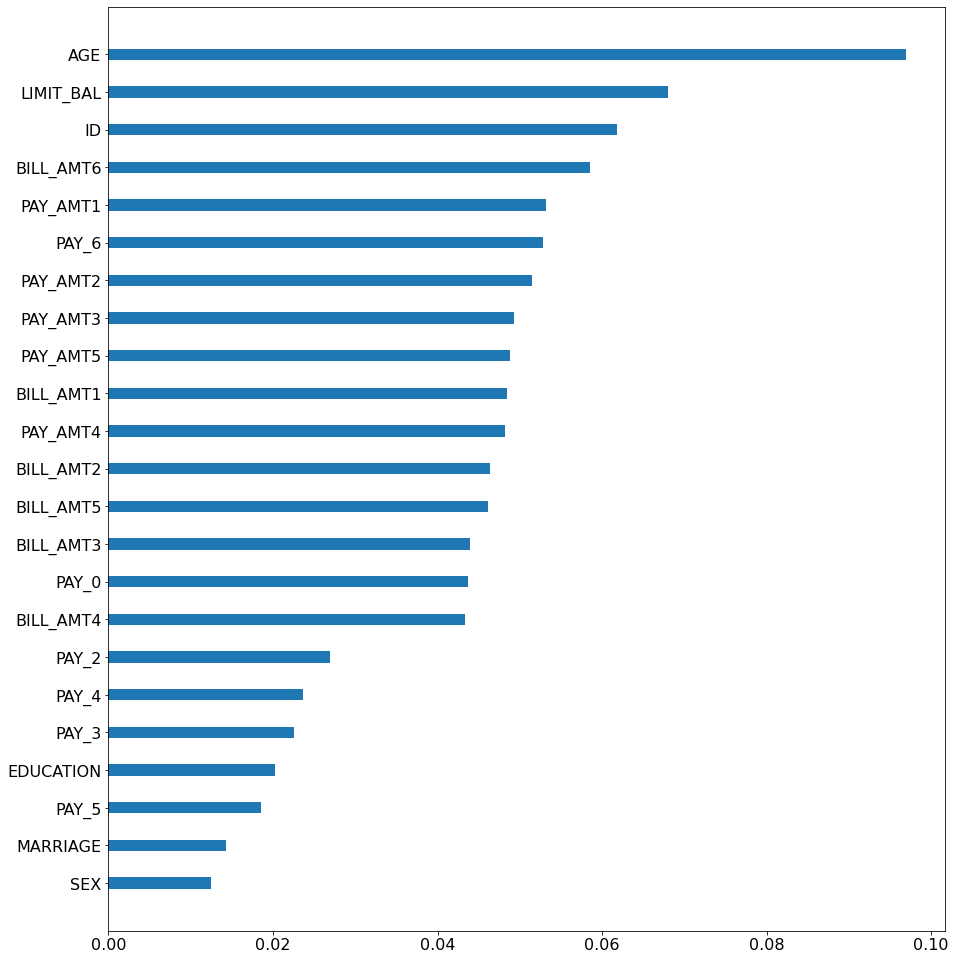

In [139]:
# Visualizar las caracterirsticas importantes
VI = classifier3.feature_importances_
features = np.array(credit.columns)
VI_sort_idx = np.argsort(VI) # sort in increasing order
plt.figure(figsize=(15,17))
plt.barh(range(VI.shape[0]), VI[VI_sort_idx], tick_label=features[VI_sort_idx], height=0.3)
plt.show()


# Evaluación

In [ ]:
Tenemos 3 modelos que brindan la misma medida en la clasificación de un cliente si va a bajar su cuota o no, por lo cual no se recomienda utilizarlos porque los porcentajes de clasificar correctamente es muy baja.

SVM
Recall	34%
Precision	68%
ROC	71%

Logistic Regression
Recall	36%
Precision	63%
ROC	76%

Naive Bayes
Recall	36%
Precision	63%
ROC	76%

K-NEIGHBOURS
Recall	36%
Precision	63%
ROC	76%
